In [1]:
import pandas as pd

In [2]:
# Assuming you’ve already loaded your files:
# sales_data, pricing_data, calendar_data, weather_data, product_info, inventory_data

# Convert column names to lowercase
def to_lowercase_columns(df):
    df.columns = df.columns.str.lower()
    return df




In [3]:
sales_data = pd.read_csv(r"C:\Users\sachi\OneDrive\Product Demand Forecasting\3_CLEANED DATA\sales_data_Cleaned.csv")
pricing_data = pd.read_csv(r"C:\Users\sachi\OneDrive\Product Demand Forecasting\3_CLEANED DATA\pricing_data_Cleaned.csv.csv")
calendar_data = pd.read_csv(r"C:\Users\sachi\OneDrive\Product Demand Forecasting\3_CLEANED DATA\Calender_Cleaned.csv.csv")
weather_data = pd.read_csv(r"C:\Users\sachi\OneDrive\Product Demand Forecasting\3_CLEANED DATA\weather_cleaned.csv")
product_info = pd.read_csv(r"C:\Users\sachi\OneDrive\Product Demand Forecasting\3_CLEANED DATA\product_info_cleaned.csv")
inventory_data  = pd.read_csv(r"C:\Users\sachi\OneDrive\Product Demand Forecasting\3_CLEANED DATA\inventory_data_Cleaned.csv.csv")

In [4]:
sales_data = to_lowercase_columns(sales_data)
pricing_data = to_lowercase_columns(pricing_data)
calendar_data = to_lowercase_columns(calendar_data)
weather_data = to_lowercase_columns(weather_data)
product_info = to_lowercase_columns(product_info)
inventory_data = to_lowercase_columns(inventory_data)

In [5]:
sales_data.shape

(494820, 5)

In [6]:
pricing_data.shape

(500000, 8)

In [7]:
calendar_data.shape

(366, 4)

In [8]:
weather_data.shape

(3660, 4)

In [9]:
product_info.shape

(500, 8)

In [10]:
inventory_data.shape

(5000, 6)

In [11]:
sales_data['date'] = pd.to_datetime(sales_data['date'], errors='coerce')
pricing_data['date'] = pd.to_datetime(pricing_data['date'], errors='coerce')

In [12]:
sales_data.dtypes

productid                object
location                 object
date             datetime64[ns]
unitssold                 int64
promocodeused            object
dtype: object

In [13]:
pricing_data.dtypes

productid                   object
location                    object
date                datetime64[ns]
price                      float64
discount_percent             int64
competitorprice            float64
adcampaign                  object
finalprice                 float64
dtype: object

In [14]:
sales_keys = sales_data[['productid', 'location', 'date']].drop_duplicates()
pricing_keys = pricing_data[['productid', 'location', 'date']].drop_duplicates()

print("Sales keys:", sales_keys.shape)
print("Pricing keys:", pricing_keys.shape)


Sales keys: (406257, 3)
Pricing keys: (437626, 3)


In [15]:
# Merge just to find missing keys
merged_keys = pd.merge(
    sales_keys,
    pricing_keys,
    on=['productid', 'location', 'date'],
    how='left',
    indicator=True
)

# Find keys present in sales but missing in pricing
missing_keys = merged_keys[merged_keys['_merge'] == 'left_only']
print("Missing key rows:", missing_keys.shape)
missing_keys.head()


Missing key rows: (309557, 4)


,productid,location,date,_merge
1,P0010,L01,2024-12-14,left_only
2,P0421,L07,2024-09-27,left_only
3,P0412,L01,2024-04-16,left_only
4,P0240,L07,2024-03-12,left_only
6,P0276,L01,2024-01-21,left_only


In [16]:
print("Unique productids in sales:", sales_data['productid'].nunique())
print("Unique productids in pricing:", pricing_data['productid'].nunique())

print("Common productids:", len(set(sales_data['productid']).intersection(set(pricing_data['productid']))))


Unique productids in sales: 500
Unique productids in pricing: 500
Common productids: 500


In [17]:
print("Unique locations in sales:", sales_data['location'].unique())
print("Unique locations in pricing:", pricing_data['location'].unique())


Unique locations in sales: ['L04' 'L01' 'L07' 'L10' 'L03' 'L08' 'L05' 'L06' 'L02' 'L09']
Unique locations in pricing: ['L06' 'L10' 'L04' 'L01' 'L09' 'L03' 'L02' 'L05' 'L08' 'L07']


In [18]:
# Check min-max dates
print("Sales date range:", sales_data['date'].min(), "to", sales_data['date'].max())
print("Pricing date range:", pricing_data['date'].min(), "to", pricing_data['date'].max())


Sales date range: 2024-01-01 00:00:00 to 2024-12-30 00:00:00
Pricing date range: 2024-01-01 00:00:00 to 2024-12-31 00:00:00


In [19]:
sales_keys = set(zip(sales_data['productid'], sales_data['location'], sales_data['date']))
pricing_keys = set(zip(pricing_data['productid'], pricing_data['location'], pricing_data['date']))

missing_keys = sales_keys - pricing_keys
print("Missing keys:", len(missing_keys))


Missing keys: 309557


In [20]:
full_keys = sales_data[['productid', 'location', 'date']].drop_duplicates()


In [21]:
pricing_expanded = pd.merge(full_keys, pricing_data, on=['productid', 'location', 'date'], how='left')


In [22]:
# Fill pricing columns with median or grouped logic
pricing_expanded['price'] = pricing_expanded['price'].fillna(pricing_expanded['price'].median())
pricing_expanded['discount_percent'] = pricing_expanded['discount_percent'].fillna(0)
pricing_expanded['competitorprice'] = pricing_expanded['competitorprice'].fillna(pricing_expanded['price'] * 1.05)

# Fill adcampaign with most common value or "None"
pricing_expanded['adcampaign'] = pricing_expanded['adcampaign'].fillna('None')


In [23]:
pricing_expanded['finalprice'] = pricing_expanded['price'] * (1 - pricing_expanded['discount_percent'] / 100)


In [24]:
merged_df = pd.merge(
    sales_data,
    pricing_expanded,
    on=['productid', 'location', 'date'],
    how='inner'
)


In [25]:
merged_df.duplicated().sum()

np.int64(0)

In [26]:
merged_df.shape

(511809, 10)

In [27]:
# Convert 'date' column to datetime in all dataframes involved in merge

merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')
calendar_data['date'] = pd.to_datetime(calendar_data['date'], errors='coerce')
weather_data['date'] = pd.to_datetime(weather_data['date'], errors='coerce')


In [28]:
# Step 1: Merge with calendar data (on 'date')
final_df = pd.merge(merged_df, calendar_data, on='date', how='left')

# Step 2: Merge with weather data (on 'location' and 'date')
final_df = pd.merge(final_df, weather_data, on=['location', 'date'], how='left')

# Step 3: Merge with product_info (on 'productid')
final_df = pd.merge(final_df, product_info, on='productid', how='left')

# Step 4: Merge with inventory_data (on 'productid' and 'location')
final_df = pd.merge(final_df, inventory_data, on=['productid', 'location'], how='left')


In [29]:
final_df.isnull().sum()

productid              0
location               0
date                   0
unitssold              0
promocodeused          0
price                  0
discount_percent       0
competitorprice        0
adcampaign             0
finalprice             0
isweekend              0
season                 0
daytype                0
temp(c)                0
rainfall(mm)           0
category               0
brand                  0
material               0
weight(kg)             0
warranty(years)        0
productrating          0
launchyear             0
stocklevel             0
supplierdelay(days)    0
warehouse              0
inventorytype          0
dtype: int64

count    511809.000000
mean          5.000035
std           3.162425
min           0.000000
25%           2.000000
50%           5.000000
75%           8.000000
max          10.000000
Name: unitssold, dtype: float64


<Axes: xlabel='unitssold', ylabel='Count'>

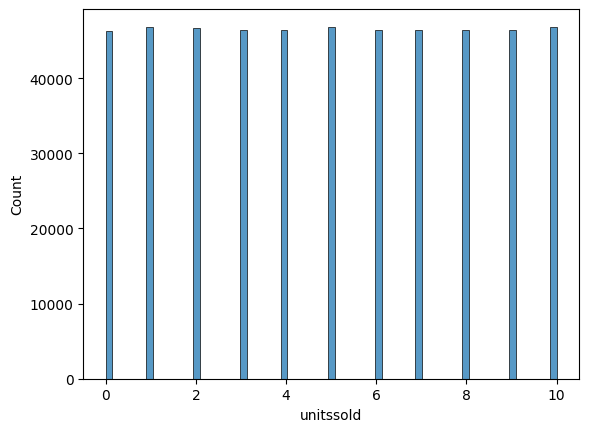

In [30]:
print(final_df['unitssold'].describe())
import seaborn as sns
sns.histplot(final_df['unitssold'])


In [31]:
import numpy as np

# Make sure these columns exist
final_df['unitssold'] = (
    200  # base demand
    - final_df['price'] * 0.5
    + final_df['discount_percent'] * 2
    + np.where(final_df['season'] == 'Winter', 10, 0)
    + np.random.normal(0, 10, size=len(final_df))  # noise
)

# Round and clip
final_df['unitssold'] = final_df['unitssold'].round().clip(lower=0)


<Axes: xlabel='unitssold', ylabel='Count'>

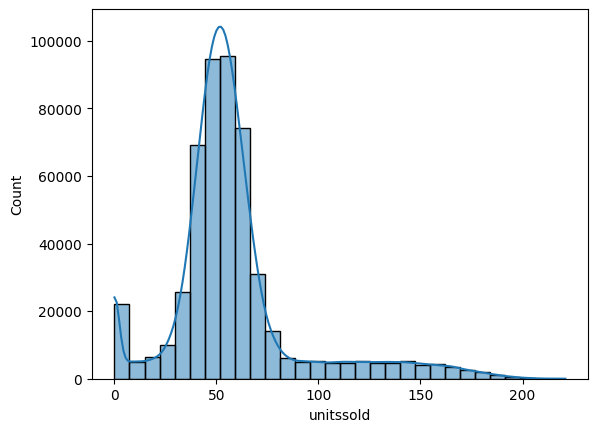

In [32]:
import seaborn as sns
sns.histplot(final_df['unitssold'], bins=30, kde=True)


In [ ]:

# final_df = final_df.sample(n=100000, random_state=42)  # random_state for reproducibility
# final_df = final_df.reset_index(drop=True)  # Optional: reset index after sampling


In [34]:
final_df.reset_index(drop=True, inplace=True)


In [35]:
final_df.shape

(511809, 26)

In [36]:
final_df.to_csv("Master_file.csv",index=False)